In [3]:
!pip -q install "transformers>=4.42.0" "datasets>=2.19.0" "accelerate>=0.31.0" \
                 "evaluate>=0.4.2" "rouge-score>=0.1.2" "sentencepiece>=0.2.0" \
                 "peft>=0.11.1" "bitsandbytes>=0.43.1" \
                 "torch>=2.2.0" "pandas>=2.0.0" "scikit-learn>=1.3.0"


In [4]:
import os, re, glob, shutil, inspect, math, random
import numpy as np, pandas as pd, torch, evaluate
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq,
    Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# ========= CONFIG =========
DATASET_PATH   = "/content/ai_behavior_profile_dataset.csv"
OUTPUT_DIR     = "/content/checkpoints/flan_t5_lora_4bit_clean"
CLEAN_OUTPUT   = True

PREFERRED_MODEL = "google/flan-t5-large"
FALLBACK_MODEL  = "google/flan-t5-base"

PROMPT_PREFIX  = "summarize nursing note: "

# Training hyperparams
NUM_EPOCHS     = 3
TRAIN_BS       = 4
EVAL_BS        = 4
GRAD_ACC_STEPS = 2
LR             = 2e-4
WARMUP_RATIO   = 0.06
WEIGHT_DECAY   = 0.0
LABEL_SMOOTH   = 0.1
LOG_STEPS      = 50
SAVE_LIMIT     = 2
PATIENCE       = 2
SEED           = 42

# Length caps (auto-adapted to 90th percentile)
MAX_INPUT_LEN_CAP  = 512
MAX_TARGET_LEN_CAP = 160

# Optional: quick iterations
FAST_MODE   = False
MAX_SAMPLES = 1500

# Precision: prefer BF16 if hw supports; otherwise no fp16 (avoid NaNs)
BF16_OK = torch.cuda.is_available() and torch.cuda.is_bf16_supported()

# ========= REPRO & CLEAN =========
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if CLEAN_OUTPUT and os.path.isdir(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ========= LOAD & PREP DATA =========
df = pd.read_csv(DATASET_PATH)

TARGET_COL = "clinicalSummary"
if TARGET_COL not in df.columns:
    raise ValueError(f"'{TARGET_COL}' not in columns: {list(df.columns)}")

INPUT_COLS = [
    "nursingNote","medications","heartRate","spo2","temperature","bloodPressure",
    "sleepHours","waterIntakeMl","mealsSkipped","exerciseMinutes",
    "behaviourTags","emotionTags","alerts"
]
INPUT_COLS = [c for c in INPUT_COLS if c in df.columns]
df[INPUT_COLS] = df[INPUT_COLS].fillna("")
df[TARGET_COL] = df[TARGET_COL].fillna("")

def make_input(row):
    parts = []
    if row.get("nursingNote",""): parts.append(f"Note: {row['nursingNote']}")
    vit = []
    if str(row.get("heartRate",""))     != "": vit.append(f"HR {row['heartRate']}")
    if str(row.get("spo2",""))          != "": vit.append(f"SpO2 {row['spo2']}")
    if str(row.get("temperature",""))   != "": vit.append(f"T {row['temperature']}")
    if str(row.get("bloodPressure","")) != "": vit.append(f"BP {row['bloodPressure']}")
    if vit: parts.append("Vitals: " + ", ".join(vit))
    if row.get("medications",""): parts.append(f"Medications: {row['medications']}")
    life = []
    if str(row.get("sleepHours",""))      != "": life.append(f"sleep h {row['sleepHours']}")
    if str(row.get("waterIntakeMl",""))   != "": life.append(f"water ml {row['waterIntakeMl']}")
    if str(row.get("mealsSkipped",""))    != "": life.append(f"meals skipped {row['mealsSkipped']}")
    if str(row.get("exerciseMinutes","")) != "": life.append(f"exercise min {row['exerciseMinutes']}")
    if life: parts.append("Lifestyle: " + ", ".join(life))
    if row.get("behaviourTags",""): parts.append(f"Behaviour: {row['behaviourTags']}")
    if row.get("emotionTags",""):   parts.append(f"Emotion: {row['emotionTags']}")
    if row.get("alerts",""):        parts.append(f"Alerts: {row['alerts']}")
    return " | ".join(parts).strip()

df["input_text"]  = df.apply(make_input, axis=1)
df["target_text"] = df[TARGET_COL].astype(str)

# Light quality filters
df["input_len"]  = df["input_text"].str.len()
df["target_len"] = df["target_text"].str.len()
df = df[(df["input_len"] >= 20) & (df["target_len"] >= 10)]
df = df.drop_duplicates(subset=["input_text","target_text"]).reset_index(drop=True)

# Optional downsample (length-balanced)
if FAST_MODE and len(df) > MAX_SAMPLES:
    lengths = df["input_len"]
    bins = pd.qcut(lengths, q=5, labels=False, duplicates="drop")
    per_bin = math.ceil(MAX_SAMPLES / bins.nunique())
    df = (df.assign(_bin=bins)
            .groupby("_bin", group_keys=False)
            .apply(lambda g: g.sample(n=min(per_bin, len(g)), random_state=SEED))
            .reset_index(drop=True)
            .drop(columns=["_bin"]))

# Split
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
split = int(len(df) * 0.9)
train_df, val_df = df.iloc[:split], df.iloc[split:]

# ========= TOKENIZER & ADAPTIVE LENGTHS =========
tok = AutoTokenizer.from_pretrained(PREFERRED_MODEL, use_fast=True)

subset = pd.concat([train_df.head(1500), val_df.head(300)], ignore_index=True)
inp_ids = tok(list((PROMPT_PREFIX + subset["input_text"]).values), truncation=False, add_special_tokens=True)["input_ids"]
tgt_ids = tok(text_target=list(subset["target_text"].values), truncation=False, add_special_tokens=True)["input_ids"]
inp_lens = np.array([len(x) for x in inp_ids]); tgt_lens = np.array([len(x) for x in tgt_ids])
MAX_INPUT_LEN  = int(min(MAX_INPUT_LEN_CAP,  np.percentile(inp_lens, 90)))
MAX_TARGET_LEN = int(min(MAX_TARGET_LEN_CAP, np.percentile(tgt_lens, 90)))
print(f"Adaptive lengths -> MAX_INPUT_LEN={MAX_INPUT_LEN}, MAX_TARGET_LEN={MAX_TARGET_LEN}")

train_ds = Dataset.from_pandas(train_df[["input_text","target_text"]], preserve_index=False)
val_ds   = Dataset.from_pandas(val_df[["input_text","target_text"]],   preserve_index=False)

def preprocess(batch):
    inputs = [PROMPT_PREFIX + x for x in batch["input_text"]]
    model_inputs = tok(inputs, max_length=MAX_INPUT_LEN, truncation=True)
    labels = tok(text_target=batch["target_text"], max_length=MAX_TARGET_LEN, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tok_train = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names, num_proc=2)
tok_val   = val_ds.map(preprocess,   batched=True, remove_columns=val_ds.column_names,   num_proc=2)

# ========= LOAD 4-bit BASE + LORA =========
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 if BF16_OK else torch.float16
)

def load_base(model_name):
    try:
        base = AutoModelForSeq2SeqLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")
        print(f"Loaded {model_name} in 4-bit.")
        return base
    except Exception as e:
        print(f"Falling back to {FALLBACK_MODEL}: {e}")
        return AutoModelForSeq2SeqLM.from_pretrained(FALLBACK_MODEL, quantization_config=bnb_config, device_map="auto")

base_model = load_base(PREFERRED_MODEL)

# ✅ Make sure decoder has a start token (T5 uses pad_token_id)
if getattr(base_model.config, "decoder_start_token_id", None) is None:
    base_model.config.decoder_start_token_id = tok.pad_token_id

# ✅ Gradient checkpointing: set use_reentrant=False to match the warning
try:
    base_model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
except TypeError:
    base_model.gradient_checkpointing_enable()
base_model.config.use_cache = False

# Prepare for k-bit training & attach LoRA
base_model = prepare_model_for_kbit_training(base_model)

lora_config = LoraConfig(
    r=16, lora_alpha=32,
    target_modules=["q","k","v","o","wi_0","wi_1","wo"],  # T5 proj layers
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(base_model, lora_config)
print(model.print_trainable_parameters())

# ⚠️ Build collator WITH THE MODEL to ensure decoder inputs are prepared
data_collator = DataCollatorForSeq2Seq(tokenizer=tok, model=model)

# ========= METRICS (ROUGE + safe decode) =========
rouge = evaluate.load("rouge")

def _safe_ids(arr, pad_id, vocab_size):
    arr = np.array(arr, dtype=np.int64)
    arr = np.where(arr < 0, pad_id, arr)
    if vocab_size is None:
        try: vocab_size = len(tok)
        except Exception: vocab_size = None
    if vocab_size is not None:
        arr = np.where(arr >= vocab_size, pad_id, arr)
    return arr

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple): preds = preds[0]
    pad_id = tok.pad_token_id if tok.pad_token_id is not None else 0
    vocab_size = getattr(tok, "vocab_size", None)
    preds  = _safe_ids(preds,  pad_id, vocab_size)
    labels = _safe_ids(labels, pad_id, vocab_size)
    decoded_preds  = tok.batch_decode(preds.tolist(),  skip_special_tokens=True)
    decoded_labels = tok.batch_decode(labels.tolist(), skip_special_tokens=True)
    decoded_preds  = [p.strip() for p in decoded_preds]
    decoded_labels = [l.strip() for l in decoded_labels]
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v*100, 2) for k, v in result.items()}

# ========= VERSION-PROOF TRAINING ARGS =========
sig_params = set(inspect.signature(Seq2SeqTrainingArguments.__init__).parameters.keys())
def keep_supported(d): return {k: v for k, v in d.items() if k in sig_params}

base_kwargs = dict(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    gradient_accumulation_steps=GRAD_ACC_STEPS,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LR,
    warmup_ratio=WARMUP_RATIO,
    weight_decay=WEIGHT_DECAY,
    logging_strategy="steps",
    logging_steps=LOG_STEPS,
    save_strategy="epoch",
    save_total_limit=SAVE_LIMIT,
    predict_with_generate=True,
    generation_max_length=MAX_TARGET_LEN,
    generation_num_beams=4,
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,
    fp16=False,
    bf16=BF16_OK,
    label_smoothing_factor=LABEL_SMOOTH,
    seed=SEED,
    report_to="none",
)

eval_kwargs = {}
if "evaluation_strategy" in sig_params: eval_kwargs["evaluation_strategy"] = "epoch"
elif "eval_strategy" in sig_params:     eval_kwargs["eval_strategy"]     = "epoch"

args = Seq2SeqTrainingArguments(**keep_supported(base_kwargs | eval_kwargs))
print("Using eval key:", "evaluation_strategy" if "evaluation_strategy" in args.to_dict() else ("eval_strategy" if "eval_strategy" in sig_params else "none"))

# ========= TRAIN =========
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tok_train,
    eval_dataset=tok_val,
    tokenizer=tok,                     # fine in transformers v4.x
    data_collator=data_collator,       # <- crucial for T5 decoder inputs
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

trainer.train()
trainer.save_model(OUTPUT_DIR)      # saves LoRA adapter
tok.save_pretrained(OUTPUT_DIR)

final_metrics = trainer.evaluate(max_length=MAX_TARGET_LEN, num_beams=4)
print("Final ROUGE (LoRA 4-bit):", final_metrics)


Adaptive lengths -> MAX_INPUT_LEN=231, MAX_TARGET_LEN=80


Map (num_proc=2):   0%|          | 0/1620 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/180 [00:00<?, ? examples/s]

Loaded google/flan-t5-large in 4-bit.
trainable params: 18,284,544 || all params: 801,434,624 || trainable%: 2.2815
None
Using eval key: eval_strategy


/tmp/ipython-input-2415497786.py:250: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.223900,2.148297,66.790000,46.570000,56.950000,56.970000
2,2.096600,2.044049,67.870000,48.020000,58.930000,58.950000
3,2.058900,2.022574,68.250000,48.630000,59.070000,59.050000


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Final ROUGE (LoRA 4-bit): {'eval_loss': 2.0225744247436523, 'eval_rouge1': 68.25, 'eval_rouge2': 48.63, 'eval_rougeL': 59.07, 'eval_rougeLsum': 59.05, 'eval_runtime': 545.1879, 'eval_samples_per_second': 0.33, 'eval_steps_per_second': 0.083, 'epoch': 3.0}


In [6]:
import os, re, glob, torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig
from peft import PeftModel

def latest_ckpt(root):
    cands = glob.glob(os.path.join(root, "checkpoint-*"))
    if not cands: return root
    def stepnum(p):
        m = re.search(r"checkpoint-(\d+)", p)
        return int(m.group(1)) if m else -1
    return max(cands, key=stepnum)

OUTPUT_DIR = "/content/checkpoints/flan_t5_lora_4bit_clean"  # adjust if different
ADAPTER_DIR = latest_ckpt(OUTPUT_DIR)
print("Using adapter from:", ADAPTER_DIR)

# Quantized base again (GPU). If no BF16 support, use FP16 compute for bnb.
BF16_OK = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 if BF16_OK else torch.float16
)

# Load base; fall back to flan-t5-base if large fails
try:
    base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large",
                                                 quantization_config=bnb_config,
                                                 device_map="auto")
except Exception as e:
    print("Falling back to flan-t5-base:", e)
    base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base",
                                                 quantization_config=bnb_config,
                                                 device_map="auto")

tok = AutoTokenizer.from_pretrained(ADAPTER_DIR, use_fast=True)

# Ensure decoder start token for T5
if getattr(base.config, "decoder_start_token_id", None) is None:
    base.config.decoder_start_token_id = tok.pad_token_id

# Attach LoRA adapter
model = PeftModel.from_pretrained(base, ADAPTER_DIR)
model.eval()

# Helper to get a good device to send inputs to (works with device_map="auto")
def _infer_device(m):
    # Prefer explicit attribute if present
    if hasattr(m, "device"):
        return m.device
    # Otherwise, look for any parameter’s device
    for p in m.parameters():
        return p.device
    # Fallback
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE = _infer_device(model)
print("Sending inputs to:", DEVICE)

def summarize(text, max_new_tokens=160, num_beams=4, prompt_prefix="summarize nursing note: "):
    enc = tok(prompt_prefix + text, return_tensors="pt", truncation=True)
    # ✅ Move ALL tensors to the same device as the model
    enc = {k: v.to(DEVICE) for k, v in enc.items()}
    with torch.no_grad():
        out = model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            no_repeat_ngram_size=3,
            early_stopping=True
        )
    return tok.decode(out[0], skip_special_tokens=True)

print(summarize("Patient alert ×3, intermittent wheeze, SpO2 95% RA, salbutamol neb given, fluids encouraged."))



Using adapter from: /content/checkpoints/flan_t5_lora_4bit_clean/checkpoint-609
Sending inputs to: cuda:0
Patient presents with fatigue, dehydration, and intermittent wheeze, with a SpO2 of 95% RA. Salbutamol neb was administered, and fluids encouraged.


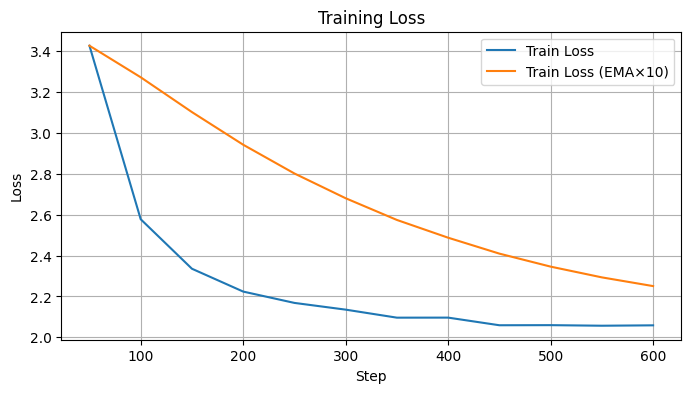

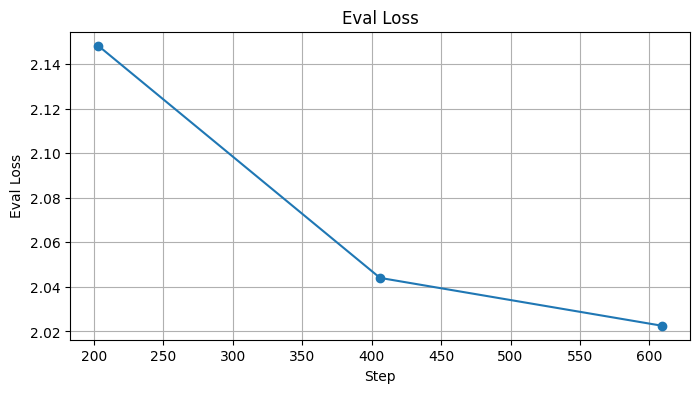

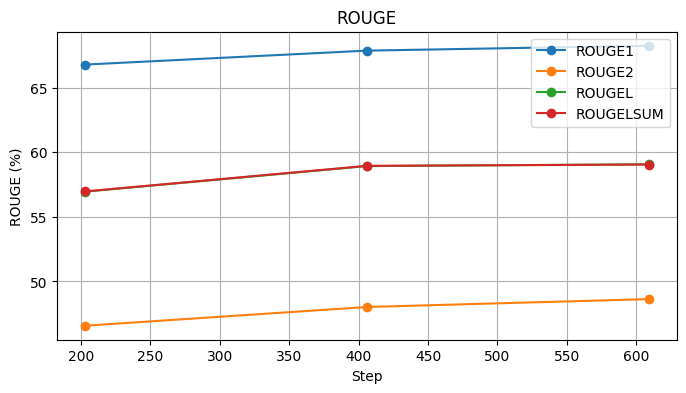

In [7]:
import os, re, glob, json, pandas as pd, matplotlib.pyplot as plt

def find_state(output_dir):
    main = os.path.join(output_dir, "trainer_state.json")
    if os.path.exists(main): return main
    cands = sorted(glob.glob(os.path.join(output_dir, "checkpoint-*", "trainer_state.json")))
    if not cands: return None
    def stepnum(p):
        m = re.search(r"checkpoint-(\d+)", p);  return int(m.group(1)) if m else -1
    return max(cands, key=stepnum)

state_path = find_state(OUTPUT_DIR)
assert state_path is not None, "No trainer_state.json found."

with open(state_path) as f:
    state = json.load(f)
log = pd.DataFrame(state.get("log_history", []))

tr = log[log["loss"].notna()][["step","loss"]].reset_index(drop=True)
if not tr.empty:
    tr["loss_ema"] = tr["loss"].ewm(span=10, adjust=False).mean()
    plt.figure(figsize=(8,4)); plt.plot(tr["step"], tr["loss"], label="Train Loss")
    plt.plot(tr["step"], tr["loss_ema"], label="Train Loss (EMA×10)")
    plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.grid(True); plt.legend(); plt.show()
else:
    print("No per-step training loss logged.")

ev_cols = ["eval_loss","eval_rouge1","eval_rouge2","eval_rougeL","eval_rougeLsum"]
ev = log[log["eval_loss"].notna()][["step"]+[c for c in ev_cols if c in log]].reset_index(drop=True)
if not ev.empty:
    plt.figure(figsize=(8,4)); plt.plot(ev["step"], ev["eval_loss"], marker="o")
    plt.xlabel("Step"); plt.ylabel("Eval Loss"); plt.title("Eval Loss"); plt.grid(True); plt.show()
    plt.figure(figsize=(8,4))
    for c in ["eval_rouge1","eval_rouge2","eval_rougeL","eval_rougeLsum"]:
        if c in ev: plt.plot(ev["step"], ev[c], marker="o", label=c.replace("eval_","").upper())
    plt.xlabel("Step"); plt.ylabel("ROUGE (%)"); plt.title("ROUGE"); plt.grid(True); plt.legend(); plt.show()
else:
    print("No eval entries logged.")
